# Swissroads Project: 07 - Dense network  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.


## Aim of this notebook  

In this jupyter notebook, we will work with the set of high-level features that have been extracted thanks to the Inception_v3 ConvNet on the tensorflow hub, to train a dense neural network classifier on our data. 
We will train our data on the train set, use the validation set to tune our hyperparameter and finally, evaluate the performance of our model with the test set. 

We will first fit a 1-layer neural network, and then, a 2-layer neural network. 


In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# loading data
# Load data
with np.load('data/train.npz', allow_pickle=False) as npz_file:
    X_tr = npz_file['features']
    y_tr = npz_file['targets']
    names_tr = npz_file['names']
    
with np.load('data/valid.npz', allow_pickle=False) as npz_file:
    X_val = npz_file['features']
    y_val = npz_file['targets']
    names_val = npz_file['names']
    
with np.load('data/test.npz', allow_pickle=False) as npz_file:
    X_te = npz_file['features']
    y_te = npz_file['targets']
    names_te = npz_file['names']

In [3]:
# numerical encoding of target variables

encoder = OrdinalEncoder()
enc_y_tr = encoder.fit_transform(y_tr.reshape(-1, 1))
enc_y_val = encoder.transform(y_val.reshape(-1, 1))
enc_y_te = encoder.transform(y_te.reshape(-1, 1))

In [4]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import optimizers

Our first step is to define a Keras wrapper in order to be able to use scikit learn cross validation grids to fine tune our dense models. 
For this first model with only 1 layer (the output layer), we do not optimize the number of units for this network. In additon, we will use the Adam optimizer for the gradient descent as it is describe as computationally efficient and adapts its momentum during the descent. 
Finally, we will tune: 
* batch size: how many images are passed to the model at a time
* learning rate: the initial value of the learning rate
* initialization method: the method used to initialize the weitght at each iteration; we choose between normal (random values drawn from a normal distribution), uniform (random values drawn from a uniform distribution) and zeros. 

Regarding the enumber of epochs, in order to avoid overfitting, we will perform the fine tuning of the other parameters on a moderate number of epochs: 50. Then, when fitting the model a final time with the optimal set of hyper parameters, we will use 1000 epochs with an early call back when the validation loss function will have stopped decreasing for at least 10 epochs


In [5]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
def onelayer_model(optimizer, learn_rate, init_mode): 
    # create model
    model = Sequential()
    model.add(Dense(6, activation = activations.softmax, input_shape=(2048,), kernel_initializer = init_mode))
    # compile model
    optimizer_grid = getattr(optimizers, optimizer)
    opt_grid = optimizer_grid(lr=learn_rate)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt_grid, metrics = ['acc'])
    return model

# fix random seed for reproducibility
seed = 20211101
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=onelayer_model, verbose=0)
# define the grid search parameters
batch_size = [8, 16, 32]
epochs = [50]
optimizer = [ 'Adam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
init_mode = ['uniform', 'normal', 'zero']


param_grid = [dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, learn_rate=learn_rate, init_mode = init_mode),
             ]
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10, verbose = 3, return_train_score = True, error_score = 'raise')
grid_result = grid.fit(np.vstack((X_tr, X_val)), np.concatenate((enc_y_tr, enc_y_val)))

Fitting 10 folds for each of 45 candidates, totalling 450 fits


In [6]:
# summarize results: 
print('Best validation accuracy achieved is {}% with {}'.format(round(grid_result.best_score_ *100,2), grid_result.best_params_))

Best validation accuracy achieved is 87.6% with {'batch_size': 32, 'epochs': 50, 'init_mode': 'zero', 'learn_rate': 0.01, 'optimizer': 'Adam'}


In [7]:
one_layer_dense_result = pd.DataFrame({
    'optimizer': grid_result.cv_results_['param_optimizer'],
    'epochs': grid_result.cv_results_['param_epochs'],
    'batch_size': grid_result.cv_results_['param_batch_size'],     
    'learn_rate': grid_result.cv_results_['param_learn_rate'],     
    'init_mode': grid_result.cv_results_["param_init_mode"],
    'mean_tr': grid_result.cv_results_['mean_train_score'],
    'mean_val': grid_result.cv_results_['mean_test_score'],
    'std_val': grid_result.cv_results_['std_test_score']
})

one_layer_dense_result.sort_values(by='mean_val', ascending = False).head(10)

,optimizer,epochs,batch_size,learn_rate,init_mode,mean_tr,mean_val,std_val
41,Adam,50,32,0.01,zero,1.0,0.876016,0.137041
20,Adam,50,16,0.001,normal,1.0,0.876016,0.127171
15,Adam,50,16,0.001,uniform,1.0,0.876016,0.126725
5,Adam,50,8,0.001,normal,1.0,0.873635,0.130360
10,Adam,50,8,0.001,zero,1.0,0.873635,0.133369
31,Adam,50,32,0.01,uniform,1.0,0.873635,0.119941
40,Adam,50,32,0.001,zero,1.0,0.873635,0.133369
36,Adam,50,32,0.01,normal,1.0,0.873635,0.140005
21,Adam,50,16,0.01,normal,1.0,0.871254,0.136786
25,Adam,50,16,0.001,zero,1.0,0.871254,0.133854


Now that we have a set of optimal hyper parameters, we fit the model a final time and evaluate it on the test set. As explained earlier, to avoid overfitting, we will use an early call back to stop the learning process when the validation loss function stops decreasing for 10 epochs. 

In [8]:
import tensorflow.keras as keras

# Compile the model
model_one_layer_def = Sequential()
model_one_layer_def.add(Dense(6, activation = activations.softmax, input_shape=(2048,), kernel_initializer = grid_result.best_params_['init_mode']))
model_one_layer_def.compile(optimizer=keras.optimizers.Adam(lr = grid_result.best_params_['learn_rate']), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Train model
# Fit model

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode = "min", patience = 50)

history = model_one_layer_def.fit(
    x=np.vstack((X_tr, X_val)), y=np.concatenate((enc_y_tr, enc_y_val)),
    validation_split=0.2, batch_size=grid_result.best_params_['batch_size'], epochs=1000, callbacks = [es],
    shuffle=True # Shuffle training samples
)



Train on 335 samples, validate on 84 samples
Epoch 1/1000
335/335 [==============================] - 0s 430us/step - loss: 1.3028 - acc: 0.5910 - val_loss: 0.6634 - val_acc: 0.7976
Epoch 2/1000
335/335 [==============================] - 0s 27us/step - loss: 0.3012 - acc: 0.9015 - val_loss: 0.5503 - val_acc: 0.8452
Epoch 3/1000
335/335 [==============================] - 0s 27us/step - loss: 0.1270 - acc: 0.9493 - val_loss: 0.3346 - val_acc: 0.9048
Epoch 4/1000
335/335 [==============================] - 0s 27us/step - loss: 0.0963 - acc: 0.9701 - val_loss: 0.5413 - val_acc: 0.8690
Epoch 5/1000
335/335 [==============================] - 0s 27us/step - loss: 0.0425 - acc: 0.9881 - val_loss: 0.3587 - val_acc: 0.8690
Epoch 6/1000
335/335 [==============================] - 0s 27us/step - loss: 0.0280 - acc: 0.9940 - val_loss: 0.4060 - val_acc: 0.8690
Epoch 7/1000
335/335 [==============================] - 0s 30us/step - loss: 0.0164 - acc: 0.9970 - val_loss: 0.3949 - val_acc: 0.9048
Epoch 8/1

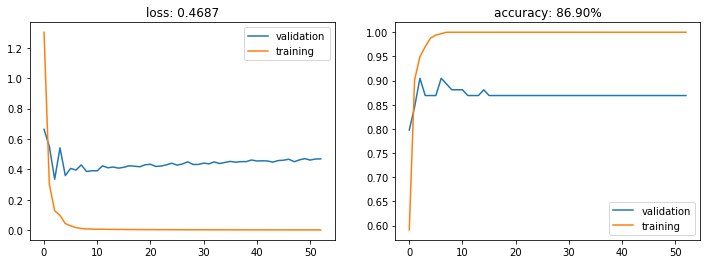

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

In [10]:
(test_loss, test_accuracy) = model_one_layer_def.evaluate(X_te, enc_y_te, batch_size=grid_result.best_params_['batch_size'])

print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy))

50/50 [==============================] - 0s 40us/step
Test loss: 0.25
Test accuracy: 94.00%


The test accuracy on our dense network containing 1 layer is 94%. 

Let's now try to see if e manage to get a bette accuracy by adding another layer. 

# Two hidden  layer

For this dense layer containing 2 layers, we will tune the same  parameters thatn for the previous network. In addition, we will also fine tune the number of units of the first layer; 

In [11]:
def twolayer_model(units, optimizer, learn_rate, init_mode): 
    # create model
    model = Sequential()
    model.add(Dense(units=units, activation=activations.relu, input_shape=(2048,),
    kernel_initializer=init_mode))
    model.add(Dense(6, activation = activations.softmax, kernel_initializer = init_mode))
    # compile model
    optimizer_grid = getattr(optimizers, optimizer)
    opt_grid = optimizer_grid(lr=learn_rate)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt_grid, metrics = ['acc'])
    return model

# fix random seed for reproducibility
seed = 20211101
np.random.seed(seed)

# create model
model2 = KerasClassifier(build_fn=twolayer_model, verbose=1)
# define the grid search parameters
units = [64, 128, 256]
batch_size = [8, 16, 32]
epochs = [50]
optimizer = [ 'Adam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
init_mode = ['uniform', 'normal', 'zero']

param_grid2 = [dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, learn_rate=learn_rate, init_mode = init_mode, units = units),
             ]
grid2 = GridSearchCV(estimator=model2, param_grid=param_grid2, n_jobs=-1, cv=10, verbose = 3, return_train_score = True, error_score = 'raise')
grid_result2 = grid2.fit(np.vstack((X_tr, X_val)), np.concatenate((enc_y_tr, enc_y_val)))

Fitting 10 folds for each of 135 candidates, totalling 1350 fits
Epoch 1/50
419/419 [==============================] - 0s 877us/step - loss: 1.1408 - acc: 0.6158
Epoch 2/50
419/419 [==============================] - 0s 117us/step - loss: 0.3371 - acc: 0.8831
Epoch 3/50
419/419 [==============================] - 0s 115us/step - loss: 0.1727 - acc: 0.9427
Epoch 4/50
419/419 [==============================] - 0s 115us/step - loss: 0.1266 - acc: 0.9523
Epoch 5/50
419/419 [==============================] - 0s 117us/step - loss: 0.1307 - acc: 0.9666
Epoch 6/50
419/419 [==============================] - 0s 117us/step - loss: 0.1291 - acc: 0.9451
Epoch 7/50
419/419 [==============================] - 0s 112us/step - loss: 0.0637 - acc: 0.9833
Epoch 8/50
419/419 [==============================] - 0s 110us/step - loss: 0.0304 - acc: 0.9881
Epoch 9/50
419/419 [==============================] - 0s 107us/step - loss: 0.0188 - acc: 0.9976
Epoch 10/50
419/419 [==============================] - 0s 107u

In [12]:
# summarize results: 
print('Best validation accuracy achieved is {}% with {}'.format(round(grid_result2.best_score_ *100,2), grid_result2.best_params_))

Best validation accuracy achieved is 88.55% with {'batch_size': 32, 'epochs': 50, 'init_mode': 'uniform', 'learn_rate': 0.01, 'optimizer': 'Adam', 'units': 128}


In [13]:
two_layer_dense_result = pd.DataFrame({
    'unit': grid_result2.cv_results_['param_units'],
    'batch_size': grid_result2.cv_results_['param_batch_size'], 
    'epochs': grid_result2.cv_results_['param_epochs'],
    'learn_rate': grid_result2.cv_results_['param_learn_rate'],
    'optimizer': grid_result2.cv_results_['param_optimizer'], 
    'init_mode': grid_result2.cv_results_["param_init_mode"],
    'mean_tr': grid_result2.cv_results_['mean_train_score'],
    'mean_val': grid_result2.cv_results_['mean_test_score'],
    'std_val': grid_result2.cv_results_['std_test_score']
})

two_layer_dense_result.sort_values(by='mean_val', ascending = False).head(10)

,unit,batch_size,epochs,learn_rate,optimizer,init_mode,mean_tr,mean_val,std_val
94,128,32,50,0.01,Adam,uniform,1.000000,0.885540,0.117452
19,128,8,50,0.01,Adam,normal,1.000000,0.883159,0.137319
3,64,8,50,0.01,Adam,uniform,0.999469,0.883159,0.113845
110,256,32,50,0.01,Adam,normal,1.000000,0.883159,0.119197
5,256,8,50,0.01,Adam,uniform,0.999735,0.880778,0.126373
105,64,32,50,0.001,Adam,normal,1.000000,0.880778,0.121804
50,256,16,50,0.01,Adam,uniform,1.000000,0.880778,0.121338
108,64,32,50,0.01,Adam,normal,1.000000,0.880778,0.122269
60,64,16,50,0.001,Adam,normal,1.000000,0.878397,0.131406
0,64,8,50,0.001,Adam,uniform,1.000000,0.878397,0.126571


Now that we have a set of optimized hyper parameters, we sill fit the model a last time, using the same process as previously to avoid overfitting. 

In [14]:
model_2 = Sequential()
model_2.add(Dense(units=grid_result2.best_params_["units"], activation=activations.relu, input_shape=(2048,),
    kernel_initializer = grid_result2.best_params_["init_mode"]))
model_2.add(Dense(6, activation=activations.softmax,  kernel_initializer = grid_result2.best_params_["init_mode"]))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 263,046
Trainable params: 263,046
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Define loss function, optimizer and metrics to track during training
model_2.compile(optimizer=keras.optimizers.Adam(lr =grid_result2.best_params_["learn_rate"]), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [16]:
# Fit model
history_2 = model_2.fit(
    x=np.vstack((X_tr, X_val)), y=np.concatenate((enc_y_tr, enc_y_val)),
    validation_split=0.2, batch_size=grid_result2.best_params_["batch_size"], epochs=1000, callbacks = [es],
    shuffle=True # Shuffle training samples
)

Train on 335 samples, validate on 84 samples
Epoch 1/1000
335/335 [==============================] - 0s 800us/step - loss: 1.1236 - acc: 0.5791 - val_loss: 0.6377 - val_acc: 0.7857
Epoch 2/1000
335/335 [==============================] - 0s 119us/step - loss: 0.2750 - acc: 0.9015 - val_loss: 0.4730 - val_acc: 0.8690
Epoch 3/1000
335/335 [==============================] - 0s 119us/step - loss: 0.1710 - acc: 0.9343 - val_loss: 0.3069 - val_acc: 0.8929
Epoch 4/1000
335/335 [==============================] - 0s 119us/step - loss: 0.1258 - acc: 0.9552 - val_loss: 0.4306 - val_acc: 0.8571
Epoch 5/1000
335/335 [==============================] - 0s 131us/step - loss: 0.0813 - acc: 0.9642 - val_loss: 0.5332 - val_acc: 0.8929
Epoch 6/1000
335/335 [==============================] - 0s 137us/step - loss: 0.0756 - acc: 0.9672 - val_loss: 0.7482 - val_acc: 0.8095
Epoch 7/1000
335/335 [==============================] - 0s 137us/step - loss: 0.0505 - acc: 0.9761 - val_loss: 0.5092 - val_acc: 0.8571
Epo

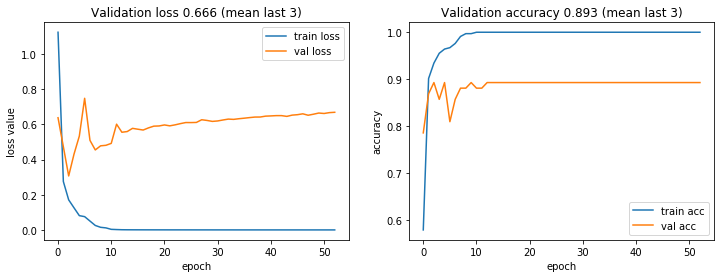

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history_2.history['loss'], label='train loss')
ax1.plot(history_2.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history_2.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history_2.history['acc'], label='train acc')
ax2.plot(history_2.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history_2.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()

In [18]:
(test_loss_2, test_accuracy_2) = model_2.evaluate(X_te, enc_y_te, batch_size=16)

print('Test loss: {:.2f}'.format(test_loss_2))
print('Test accuracy: {:.2f}%'.format(100*test_accuracy_2))

50/50 [==============================] - 0s 120us/step
Test loss: 0.33
Test accuracy: 94.00%


After tuning the 2-layer dense network, we also achieved a test accuracy of 94%. 

Finally, we save these result to compare them to all the other methods. 

In [19]:
np.savez('results/07_one_layer_dense.npz', test_accuracy=test_accuracy)
np.savez('results/08_two_layer_dense.npz', test_accuracy=test_accuracy_2)